# WORKSHOP 2

------------

**<u>GRUPO 4<u>**

Digital House

link git hub: https://github.com/grupo4dhds/grupo4_git.git

--------------
## ACLARACIONES

**Cambio en la convensión de Dicto[keys], a partir de ahora la posición [0] se utiliza para el dataset main y el resto de indices para datas auxiliares**
    
## CONTENIDO

After cell 12:
    
    Dicto.keys():
        - data_cruda
        - surface_nan
        - data
        - dummy_place

Celda 12:
    
    * implementación del modelo machine learning
    
Celda 18:
    
    * prediccion del modelo sobre una muestra de datos extraídos de otra sección del dataset original
    
Celda 19: (mask_2 ask)
    
    * me parece que estamos excluyendo valores de la muestra,
    
    * porque la serie_same contempla "otros" (y la muestra claramente no fue categorizada).
    
    * Posible solucion: tener un diccionario que emparente otros con todos los otros:

    if muestra.place_name.isin(diccionario.keys()):
        muestra['place_name_2'] = diccionario.values()

Celda 21:
    
    * Recordar que esta muestra viene de otro criterio de seleccion, y por eso es necesario matchiar valores estadísticos que se calcularon sin ser estos elementos parte de la muestra

Celda 25:    
    
    * Guardado de la data: Dicto['muestra']
    
Celda 27:
    
    * Comprobación visual del rango de aplicacion del modelo: (aclaracion en parte 2 - After regularizacón)
    
Celda 29: 
    
    * Chequear esa celda que trabaja con un data_aux, no entiendo la complicación de empalme que podría estar sucediendo
    
Celda 31: 
    
    * grafico - visualizacion
    
... continua con regularizacion

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression

In [3]:
def lista_featurend(X, label_i):
    for i in range(len(X.columns)):
        if list(X.columns)[i] == label_i:
            lista_featur_end = (list(X.columns)[i:])
    return lista_featur_end
        
def cambia_nombre_columnas(data, **kwarg):
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html
    for key in kwarg.keys():
        data.rename(kwarg[key], axis=1, inplace=True)
    return data

def cambia_orden_columnas(check_list, data, safe=1): # safe: es para conservar la primera columna con indice[0]
    label_list = list(data.columns)
    for i in range(len(check_list)):
        label_list.remove(check_list[i])
        label_list.insert(i+safe, check_list[i])
        data = data.reindex(label_list, axis=1)
        
def data_info(data, name='data'):
    df = pd.DataFrame(pd.Series(data.columns))
    df.columns = ['columna']
    df.columns.name = f'df de {name}'
    df.index.name = 'index'
    df['Nan'] = data.isna().sum().values
    df['dtype']  = data.dtypes.values
    df['count'] = data.count().values
    df['pct_nan'] = round(df['Nan']/data.shape[0]*100,2)
    df['count_unique'] = [len(data[elemento].value_counts()) for elemento in data.columns]
    return df


def visualizacion_dos_scatter(frame1, frame2, x, y_1, y_2):
    x1 = frame1[x]
    x2 = frame2[x]
    y_real = frame1[y_1]
    y_pred = frame2[y_2]
    plt.scatter(x1, y_real)
    plt.scatter(x2, y_pred) # muestra, entonces com
    plt.suptitle('y, y_pred');
    
    
    ax = plt.axes() #instancia de un objeto
    # tiene atributos y tiene métodos
    # los atributos .algo y los métodos son .algo()
    # 
    ax.set(xlabel = 'x', ylabel='price')
    #azules reales
    #naranjas predichos
    

    """
dame dos datasets, ya filtrados

# separame el eje x, de cualquier de los dos datasets
# armame una serie de cada valor real/predicho
""";
def variables_feature(frame):
    frame['sup_total_pow2'] = frame.surface_total_in_m2 * frame.surface_total_in_m2
    frame['sup_descubierta'] = frame.surface_total_in_m2 - frame.surface_covered_in_m2
    frame['sup_descubierta_pct'] = frame.sup_descubierta / frame.surface_total_in_m2 *100
    frame = frame.drop('sup_descubierta', axis=1)
    return frame

def analisis_nans(frame):
    df = data_info(frame)
    lista_not_na = list((df[df.Nan == 0].columna).values)
    lista_con_na = list((df[df.Nan != 0].columna).values)
    
    print ('ANALISIS DE NANS')
    print (frame[lista_con_na].isna().sum().to_string())
    #print ('La suma es {}'.format(3198+746))
    print ('Cantidad de elemento: {}'.format(frame[lista_con_na].shape[0]))
    print ('Interseccion entre los nan encuentra: {} elementos'.format(frame[lista_con_na].isna().all(axis=1).sum()))
    print('Union entre los nan encuentra: {} elementos'.format(frame[lista_con_na].isna().any(axis=1).sum()))

In [4]:
data = pd.read_csv('data_apartment_5_final.csv')
data.drop(list(data.columns)[0], axis=1, inplace=True)
lista_columnas_1 = list(data.columns)[:9]
lista_columnas_2 = lista_featurend(data,'above_mean')
print(lista_columnas_1)
print(lista_columnas_2)
data = data.loc[:,lista_columnas_1 + lista_columnas_2]

Dicto = {}

['property_type', 'place_name', 'state_name', 'price', 'currency', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'place_name_2']
['above_mean', 'above_median']


In [5]:
df = data_info(data)
df

df de data,columna,Nan,dtype,count,pct_nan,count_unique
index,,,,,,
0,property_type,0,object,15942,0.00,1
1,place_name,0,object,15942,0.00,113
2,state_name,0,object,15942,0.00,5
3,price,0,float64,15942,0.00,2671
4,currency,0,object,15942,0.00,1
5,surface_total_in_m2,3198,float64,12744,20.06,168
6,surface_covered_in_m2,746,float64,15196,4.68,191
7,price_usd_per_m2,0,float64,15942,0.00,6332
8,place_name_2,0,object,15942,0.00,51


In [6]:
lista_not_na = list((df[df.Nan == 0].columna).values)
lista_con_na = list((df[df.Nan != 0].columna).values)

In [7]:
print ('ANALISIS DE NANS')
print (data[lista_con_na].isna().sum().to_string())
print ('La suma es {}'.format(3198+746))
print ('Cantidad de elemento: {}'.format(data[lista_con_na].shape[0]))

print ('Interseccion entre los nan encuentra: {} elementos'.format(data[lista_con_na].isna().all(axis=1).sum()))
print('Union entre los nan encuentra: {} elementos'.format(data[lista_con_na].isna().any(axis=1).sum()))

print ('\nSe toma muestra de los valores y se los quita del dataset')

muestra = data[data[lista_con_na].isna().any(axis=1)]
df = data_info(muestra, 'surface_nan')
data = data.drop(muestra.index)

Dicto['data_cruda'] = data.to_dict(), data_info(data).to_dict()
Dicto['surface_nan'] = muestra.to_dict(), df.to_dict()

ANALISIS DE NANS
surface_total_in_m2      3198
surface_covered_in_m2     746
La suma es 3944
Cantidad de elemento: 15942
Interseccion entre los nan encuentra: 0 elementos
Union entre los nan encuentra: 3944 elementos

Se toma muestra de los valores y se los quita del dataset


In [8]:
data

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,place_name_2,above_mean,above_median
0,apartment,Mataderos,Capital Federal,72000.000000,USD,55.0,55.0,1309.090909,Mataderos,0.0,1.0
1,apartment,Mataderos,Capital Federal,67000.000000,USD,40.0,28.0,1675.000000,Mataderos,0.0,0.0
2,apartment,Mataderos,Capital Federal,90000.000000,USD,52.0,48.0,1730.769231,Mataderos,0.0,1.0
3,apartment,Mataderos,Capital Federal,88000.000000,USD,50.0,38.0,1760.000000,Mataderos,0.0,0.0
4,apartment,Mataderos,Capital Federal,93600.000000,USD,51.0,46.0,1835.294118,Mataderos,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
15937,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,63759.245132,USD,36.0,33.0,1752.614722,otros,0.0,1.0
15938,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,63759.245132,USD,36.0,33.0,1752.614722,otros,0.0,1.0
15939,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,52140.893797,USD,30.0,28.0,1719.899333,otros,0.0,0.0
15940,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,58375.131099,USD,34.0,32.0,1699.005294,otros,0.0,0.0


In [9]:
data = variables_feature(data)

dummy_place = pd.get_dummies(data['place_name_2'])
df = data_info(dummy_place)['columna']

place_name_2 = data.place_name_2
data = data.drop('place_name_2', axis=1)

Dicto['data'] = data.to_dict(), data_info(data).to_dict()
Dicto['dummy_place'] = dummy_place.to_dict(), df.to_dict()

In [10]:
data

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,above_mean,above_median,sup_total_pow2,sup_descubierta_pct
0,apartment,Mataderos,Capital Federal,72000.000000,USD,55.0,55.0,1309.090909,0.0,1.0,3025.0,0.000000
1,apartment,Mataderos,Capital Federal,67000.000000,USD,40.0,28.0,1675.000000,0.0,0.0,1600.0,30.000000
2,apartment,Mataderos,Capital Federal,90000.000000,USD,52.0,48.0,1730.769231,0.0,1.0,2704.0,7.692308
3,apartment,Mataderos,Capital Federal,88000.000000,USD,50.0,38.0,1760.000000,0.0,0.0,2500.0,24.000000
4,apartment,Mataderos,Capital Federal,93600.000000,USD,51.0,46.0,1835.294118,0.0,0.0,2601.0,9.803922
...,...,...,...,...,...,...,...,...,...,...,...,...
15937,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,63759.245132,USD,36.0,33.0,1752.614722,0.0,1.0,1296.0,8.333333
15938,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,63759.245132,USD,36.0,33.0,1752.614722,0.0,1.0,1296.0,8.333333
15939,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,52140.893797,USD,30.0,28.0,1719.899333,0.0,0.0,900.0,6.666667
15940,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,58375.131099,USD,34.0,32.0,1699.005294,0.0,0.0,1156.0,5.882353


In [11]:
print (pd.Series(data.columns).to_string())

0             property_type
1                place_name
2                state_name
3                     price
4                  currency
5       surface_total_in_m2
6     surface_covered_in_m2
7          price_usd_per_m2
8                above_mean
9              above_median
10           sup_total_pow2
11      sup_descubierta_pct


In [12]:
# 1. Seleccion de la clase de modelo
from sklearn.linear_model import LinearRegression

# 2. Elegir los hiperparámetros del modelo
linreg = LinearRegression(normalize=True) # False: default but then change to True and see changes

#3. Preparar los datos en una matriz de features, y un vector target

features_1 = ['surface_total_in_m2', 'sup_total_pow2', 'sup_descubierta_pct', 'above_mean']
features_2 = ['surface_total_in_m2', 'sup_total_pow2', 'sup_descubierta_pct', 'above_median']

X = data[features_1]
X = pd.concat([X,dummy_place], axis=1)


y = data.price
y = y[y.index.intersection(X.index)]

#4. Separar los sets de entrenamiento y de testing
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

#5. Ajustar el modelo a los datos de entrenamiento
linreg.fit(Xtrain, ytrain)

#6. Predecir etiquetas para datos desconocidos
y_pred = linreg.predict(Xtest)

#7. Evaluar la perfomance del modelo

from sklearn import metrics

print ('MAE:', metrics.mean_absolute_error(ytest, y_pred))
print ('MSE:', metrics.mean_squared_error(ytest, y_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, y_pred)))
print ('R2:', metrics.r2_score(ytest, y_pred))

MAE: 26221.099962067852
MSE: 1309469393.2819934
RMSE: 36186.591346547044
R2: 0.8298430396074956


In [13]:
#import statsmodels as sm # error
#help(LinearRegression)
#help(LinearRegression.predict)
#help(sm.fittedvalues) # no logro hacerlo funcionar proviene de la notebook de dani
"""
    VALORES CON valor=84, valor: cantidad de publicaciones minimas para conservar place_name
Normalize: False (no varía si se cambia a True)
MAE: 26388.597029743163
MSE: 1290767140.9256575
RMSE: 35927.247889668055
R2: 0.8201073191954292

    VALORES CON valor=63
    feature_1
MAE: 26105.609540740712
MSE: 1266840578.3410313
RMSE: 35592.70400434661
R2: 0.828237097073263
    VALORES CON valor=63
    feature_2
MAE: 26093.385049955825
MSE: 1266894552.180633
RMSE: 35593.462211207174
R2: 0.8282297791016645
    diferencia
f2-f1 (MAE) = -12
f2-f1 (MSE) = 53.974 (elegimos feature 1)
f2-f1 (RMSE) = 1
f2-f1 (R2) = -0,000008

(wrong!)    VALORES = 63 : otros
    feature_1
    select: surface_covered_in_m2
MAE: 25885.978562020075
MSE: 1286649928.941028
RMSE: 35869.90282870903
R2: 0.8255512724933425

""";

--------------------
**EVALUACION VISUAL DEL MODELO CON DATOS DE OTRA MUESTRA PERO QUE SEAN REPRESENTATIVOS DE ESTA**

In [14]:
data_aux = pd.DataFrame(Dicto['data'][0])

features_1
lista = []
for i in range(len(list(data_aux.columns))):
    booleano = False
    for j in range(len(features_1)):
        elemento = features_1[j] in list(data_aux.columns)[i]
        if elemento: 
            booleano = True            
    lista.append(booleano)
    
not_features_1 = []
for i in range(len(lista)):
    if lista[i] == False:
        not_features_1.append(list(data_aux.columns)[i])
        
data_aux = data_aux[not_features_1]
data_aux = data_aux.drop('above_median', axis=1)

data_aux.head(1)

,property_type,place_name,state_name,price,currency,surface_covered_in_m2,price_usd_per_m2
0,apartment,Mataderos,Capital Federal,72000.0,USD,55.0,1309.090909


In [15]:
#########CREACION COLUMNA y_pred
data = data[features_1]
data = pd.concat([data,dummy_place], axis=1)
array_predict = linreg.predict(data)
data['y_pred'] = array_predict
data.head(1)

,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct,above_mean,Abasto,Acassuso,Adrogué,Balvanera,Banfield,Barracas,...,Santos Lugares,Victoria,Villa Bosch,Villa Crespo,Villa Devoto,Villa Luzuriaga,Villa Pueyrredón,Wilde,otros,y_pred
0,55.0,3025.0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,122728.568356


In [16]:
data = pd.concat([data_aux,data], axis=1)
data.head(1)


,property_type,place_name,state_name,price,currency,surface_covered_in_m2,price_usd_per_m2,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct,...,Santos Lugares,Victoria,Villa Bosch,Villa Crespo,Villa Devoto,Villa Luzuriaga,Villa Pueyrredón,Wilde,otros,y_pred
0,apartment,Mataderos,Capital Federal,72000.0,USD,55.0,1309.090909,55.0,3025.0,0.0,...,0,0,0,0,0,0,0,0,0,122728.568356


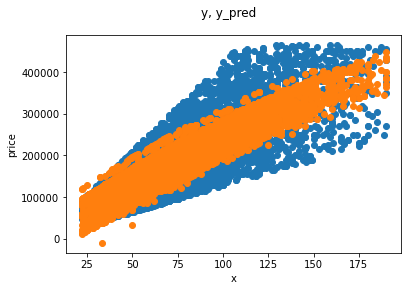

In [17]:
visualizacion_dos_scatter(data,data,'surface_total_in_m2', 'price','y_pred')

--------------------
**EXPLORACION DE LA MUESTRA**

In [18]:
serie_same = pd.Series(Dicto['dummy_place'][1])
serie_same;

In [19]:
muestra = pd.read_csv('muestra_currency_nan.csv')
muestra = muestra.drop(list(muestra.columns)[0], axis=1)
mask_1 = muestra.property_type == 'apartment'
mask_2 = muestra.place_name.isin(serie_same)

muestra = muestra[mask_1 & mask_2]

muestra = variables_feature(muestra)
muestra

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,sup_total_pow2,sup_descubierta_pct
35,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,55.0,55.0,NaN,3025.0,0.000000
46,apartment,Recoleta,Capital Federal,NaN,NaN,147.0,135.0,NaN,21609.0,8.163265
61,apartment,Balvanera,Capital Federal,NaN,NaN,76.0,76.0,NaN,5776.0,0.000000
74,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,120.0,NaN,14400.0,0.000000
75,apartment,Villa Devoto,Capital Federal,NaN,NaN,68.0,NaN,NaN,4624.0,NaN
...,...,...,...,...,...,...,...,...,...,...
15530,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,94.0,NaN,10000.0,6.000000
15531,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,53.0,44.0,NaN,2809.0,16.981132
15533,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,52.0,48.0,NaN,2704.0,7.692308
15535,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,NaN,70.0,NaN,NaN,NaN


In [20]:
display (data_info(muestra,'muestra'))
analisis_nans(muestra.loc[:,['surface_total_in_m2', 'surface_covered_in_m2','place_name']])
print ()
print ('Accion a tomar: limpiar en funcion de los nans de "sup_descubierta_pct"')

muestra = muestra.loc[muestra.sup_descubierta_pct.notna()]
muestra

df de muestra,columna,Nan,dtype,count,pct_nan,count_unique
index,,,,,,
0,property_type,0,object,1959,0.00,1
1,place_name,0,object,1959,0.00,46
2,state_name,0,object,1959,0.00,6
3,price,1959,float64,0,100.00,0
4,currency,1959,float64,0,100.00,0
5,surface_total_in_m2,147,float64,1812,7.50,210
6,surface_covered_in_m2,394,float64,1565,20.11,181
7,price_usd_per_m2,1959,float64,0,100.00,0
8,sup_total_pow2,147,float64,1812,7.50,210


ANALISIS DE NANS
surface_total_in_m2      147
surface_covered_in_m2    394
Cantidad de elemento: 1959
Interseccion entre los nan encuentra: 0 elementos
Union entre los nan encuentra: 541 elementos

Accion a tomar: limpiar en funcion de los nans de "sup_descubierta_pct"


,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,sup_total_pow2,sup_descubierta_pct
35,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,55.0,55.0,NaN,3025.0,0.000000
46,apartment,Recoleta,Capital Federal,NaN,NaN,147.0,135.0,NaN,21609.0,8.163265
61,apartment,Balvanera,Capital Federal,NaN,NaN,76.0,76.0,NaN,5776.0,0.000000
74,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,120.0,NaN,14400.0,0.000000
83,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,120.0,NaN,14400.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
15529,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,94.0,NaN,10000.0,6.000000
15530,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,94.0,NaN,10000.0,6.000000
15531,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,53.0,44.0,NaN,2809.0,16.981132
15533,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,52.0,48.0,NaN,2704.0,7.692308


In [21]:
data_check = pd.read_csv('data_apartment_4_statistic.csv')
data_check = data_check.rename({'Unnamed: 0':'place_name'}, axis=1)
data_check.set_index('place_name', inplace=True)

apartment_mean = data_check['apartment_mean_surface_total_in_m2'].dropna()
lista_place_name = apartment_mean.index
lista_apartment_mean = apartment_mean.values

for i, elemento in enumerate(lista_place_name):
    #display(np.array((muestra.loc[mascara_iter_1 & (muestra.place_name == elemento), 'surface_total_in_m2']) >= lista_apartment_mean[i]).astype(int)) # columna dummy
    muestra.loc[(muestra.place_name == elemento), 'above_mean'] = np.array((muestra.loc[(muestra.place_name == elemento), 'surface_total_in_m2']) >= lista_apartment_mean[i]).astype(int)
    
muestra

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,sup_total_pow2,sup_descubierta_pct,above_mean
35,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,55.0,55.0,NaN,3025.0,0.000000,0.0
46,apartment,Recoleta,Capital Federal,NaN,NaN,147.0,135.0,NaN,21609.0,8.163265,1.0
61,apartment,Balvanera,Capital Federal,NaN,NaN,76.0,76.0,NaN,5776.0,0.000000,1.0
74,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,120.0,NaN,14400.0,0.000000,1.0
83,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,120.0,NaN,14400.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...
15529,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,94.0,NaN,10000.0,6.000000,1.0
15530,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,94.0,NaN,10000.0,6.000000,1.0
15531,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,53.0,44.0,NaN,2809.0,16.981132,1.0
15533,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,52.0,48.0,NaN,2704.0,7.692308,1.0


In [22]:
##dummy de la muestra, reacondicionamiento
dummy_place_sample = pd.get_dummies(muestra.place_name)

lista_dummy_original = serie_same.values
lista_dummy_muestra = dummy_place_sample.columns

difference_1 = set(lista_dummy_original).difference(set(lista_dummy_muestra))
difference_2 = set(lista_dummy_muestra).difference(set(lista_dummy_original))
list_difference = list(difference_1.union(difference_2))
print(list_difference)#https://www.delftstack.com/es/howto/python/difference-between-two-lists-python/

dummy_place_sample.loc[:,difference_1] = 0
dummy_place_sample.columns;

['San Justo', 'Barrio Los Alisos', 'Adrogué', 'Villa Bosch', 'Villa Luzuriaga', 'Wilde', 'Beccar', 'otros']


In [23]:
serie_same;

In [24]:
#X = muestra[features_1]
X = pd.concat([muestra[features_1], dummy_place_sample], axis=1)
X


,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct,above_mean,Abasto,Acassuso,Balvanera,Banfield,Barracas,Barrio Norte,...,Villa Devoto,Villa Pueyrredón,San Justo,Barrio Los Alisos,Adrogué,Villa Bosch,Villa Luzuriaga,Wilde,Beccar,otros
35,55.0,3025.0,0.000000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46,147.0,21609.0,8.163265,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,76.0,5776.0,0.000000,1.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74,120.0,14400.0,0.000000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83,120.0,14400.0,0.000000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15529,100.0,10000.0,6.000000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15530,100.0,10000.0,6.000000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15531,53.0,2809.0,16.981132,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15533,52.0,2704.0,7.692308,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
muestra['y_pred'] = linreg.predict(X)
Dicto['muestra'] = muestra.to_dict(), data_info(muestra, 'muestra')
muestra

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,sup_total_pow2,sup_descubierta_pct,above_mean,y_pred
35,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,55.0,55.0,NaN,3025.0,0.000000,0.0,108106.151532
46,apartment,Recoleta,Capital Federal,NaN,NaN,147.0,135.0,NaN,21609.0,8.163265,1.0,309238.719875
61,apartment,Balvanera,Capital Federal,NaN,NaN,76.0,76.0,NaN,5776.0,0.000000,1.0,196266.112129
74,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,120.0,NaN,14400.0,0.000000,1.0,253111.530299
83,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,120.0,NaN,14400.0,0.000000,1.0,253111.530299
...,...,...,...,...,...,...,...,...,...,...,...,...
15529,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,94.0,NaN,10000.0,6.000000,1.0,219135.728994
15530,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,94.0,NaN,10000.0,6.000000,1.0,219135.728994
15531,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,53.0,44.0,NaN,2809.0,16.981132,1.0,100094.108227
15533,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,52.0,48.0,NaN,2704.0,7.692308,1.0,103782.384828


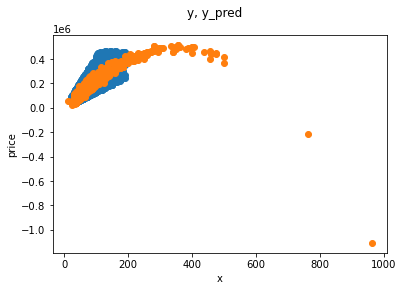

In [26]:
visualizacion_dos_scatter(data,muestra, x='surface_total_in_m2', y_1='price', y_2='y_pred')
# x: surface_total_in_m2
# puntos azules: valores reales de departamentos
# puntos naranjas: valores predicho sobre una muestra sin valores reales

    Conclusion:
        
        - El modelo predice mal para valores grandes de departamentos.
        - Se debe diferenciar por place_name para identificar los barrios en los que el modelo responde al patrón de precios

------------
**COMPROBACION VISUAL DEL RANGO DE APLICACION DEL MODELO**

In [27]:
dataview_1 = data[['property_type','surface_total_in_m2']]
dataview_1['place_name'] = place_name_2
dataview_1['price'] = data.price

dataview_1['id'] = 1

dataview_1

,property_type,surface_total_in_m2,place_name,price,id
0,apartment,55.0,Mataderos,72000.000000,1
1,apartment,40.0,Mataderos,67000.000000,1
2,apartment,52.0,Mataderos,90000.000000,1
3,apartment,50.0,Mataderos,88000.000000,1
4,apartment,51.0,Mataderos,93600.000000,1
...,...,...,...,...,...
15937,apartment,36.0,otros,63759.245132,1
15938,apartment,36.0,otros,63759.245132,1
15939,apartment,30.0,otros,52140.893797,1
15940,apartment,34.0,otros,58375.131099,1


In [28]:
dataview_2 = muestra[['property_type', 'surface_total_in_m2', 'place_name', 'y_pred']]

place_missing = set(place_name_2).difference(set(muestra.place_name)) # eliminar de la muestra original

dataview_2['id'] = 2

dataview_2

,property_type,surface_total_in_m2,place_name,y_pred,id
35,apartment,55.0,La Plata,108106.151532,2
46,apartment,147.0,Recoleta,309238.719875,2
61,apartment,76.0,Balvanera,196266.112129,2
74,apartment,120.0,La Plata,253111.530299,2
83,apartment,120.0,La Plata,253111.530299,2
...,...,...,...,...,...
15529,apartment,100.0,Castelar,219135.728994,2
15530,apartment,100.0,Castelar,219135.728994,2
15531,apartment,53.0,Castelar,100094.108227,2
15533,apartment,52.0,Castelar,103782.384828,2


In [29]:
dataview_1 = dataview_1.drop(dataview_1[dataview_1.place_name.isin(list(place_missing))].index)
#
print ('Si eliminamos los elementos de place_missing de la muestra de entrenamiento, estaríamos entrenando ajustando a esta muestra de verificacion.')
#
dataview_1

Si eliminamos los elementos de place_missing de la muestra de entrenamiento, estaríamos entrenando ajustando a esta muestra de verificacion.


,property_type,surface_total_in_m2,place_name,price,id
0,apartment,55.0,Mataderos,72000.000000,1
1,apartment,40.0,Mataderos,67000.000000,1
2,apartment,52.0,Mataderos,90000.000000,1
3,apartment,50.0,Mataderos,88000.000000,1
4,apartment,51.0,Mataderos,93600.000000,1
...,...,...,...,...,...
15638,apartment,75.0,Güemes,168000.000000,1
15639,apartment,75.0,Güemes,155546.714375,1
15640,apartment,61.0,Güemes,132000.000000,1
15641,apartment,61.0,Güemes,123511.349226,1


In [30]:
dataview_2.rename({'y_pred': 'price'}, axis=1, inplace=True)
dataview_1 = dataview_1.append(dataview_2)

In [31]:
#g = sns.FacetGrid(dataview_1, row = 'place_name', hue='id', sharex=False, sharey=False)
#g.map(sns.scatterplot, 'surface_total_in_m2', 'price')
#g.add_legend()


###  Parte 2 - Ridge


-35- Crear llave Dicto que sea Dicto['data_pred']

-36- error- usamos una variable superficie cubierta- Crear llave Dicto que sea Dicto['X_Ridge']# asumo que el _std (convension) se implementa en caso de ser necesario luego de cargar la matriz de features

- tener un diccionario de modelo, entr la celda 40 y la 41, Model['model_ridge']= model_fit_ridge; además, una cosa es el feature que se parece al data, y otra es el feature con el que se divide- pensalo

porque?, porque puedo hacer Model.keys() y ver todos los modelos entrenados que tengo
ademas, puedo hacer Model['model_ridge'] = model_fit_ridge, Dicto[X_ridge], Y los coeficientes...

Dictures*

-46- frene de leer

In [32]:
import numpy as np
import pandas as pd


from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [33]:
def check_fit_transform(X):
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    X.columns.name = 'fit_transform'
    return display(X)

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11998 entries, 0 to 15941
Data columns (total 63 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   property_type          11998 non-null  object 
 1   place_name             11998 non-null  object 
 2   state_name             11998 non-null  object 
 3   price                  11998 non-null  float64
 4   currency               11998 non-null  object 
 5   surface_covered_in_m2  11998 non-null  float64
 6   price_usd_per_m2       11998 non-null  float64
 7   surface_total_in_m2    11998 non-null  float64
 8   sup_total_pow2         11998 non-null  float64
 9   sup_descubierta_pct    11998 non-null  float64
 10  above_mean             11998 non-null  float64
 11  Abasto                 11998 non-null  uint8  
 12  Acassuso               11998 non-null  uint8  
 13  Adrogué                11998 non-null  uint8  
 14  Balvanera              11998 non-null  uint8  
 15  Ba

In [35]:
### limpiando el dataset: Como eliminar las últuimas columnas - recordar que serie_pred la guardamos antes porque la queremos conservar luego del drop
### al final no fue el tratamiento correcto, sino quedarnos solo con las variables tipo float

#serie_pred = data.y_pred
#lista_drop = lista_featurend(data, 'Abasto')
#data = data.drop(lista_drop, axis=1)
#data = pd.concat([data, serie_pred], axis=1)
#data

serie_y_pred = data.y_pred
data = data.drop('y_pred', axis=1)      


In [36]:
scaler = StandardScaler()
### X = scaler.fit_transform(data)    error: falta el procedimiento a continuacion

df = data_info(data)
## data.loc[:,data.columns.isin(df[df['dtype'] == 'float64'].columna.values)] #check
X = data.loc[:,data.columns.isin(df[df['dtype'] == 'float64'].columna.values)]
X = X.drop(['price', 'above_mean', 'price_usd_per_m2'], axis=1)

y = data.price

check_fit_transform(X) #funcion creada


X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#lista_drop = lista_featurend(data, 'above_mean')   <--- eliminamos los dummy por el error
"""
model_ridge_cv = linear_model.RidgeCV(alphas= [0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 10.0], 
                                   fit_intercept=True, normalize=False, cv=10)
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
"""
# la situacion no cambia:
# cambiamos entonces a 
#X_std.loc[:,'above_mean'] = data.loc[:,'above_mean']
# la situacion no cambia:
# sacamos entonces la variable categorica above_mean: y eso resuelve!


#X_std = pd.concat([X_std, data.loc[:,lista_drop]], axis=1)
X_std.columns.name='X_std'
display (X_std)


## error: en este modelo consideramos la superficie cubierta, la total y la porcentual

fit_transform,surface_covered_in_m2,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct
0,-0.100263,-0.330335,-0.406726,-0.901216
1,-1.105988,-0.815811,-0.672402,1.775178
2,-0.361007,-0.427430,-0.466573,-0.214961
3,-0.733497,-0.492160,-0.504607,1.239899
4,-0.435505,-0.459795,-0.485777,-0.026578
...,...,...,...,...
11993,-0.919743,-0.945271,-0.729080,-0.157773
11994,-0.919743,-0.945271,-0.729080,-0.157773
11995,-1.105988,-1.139461,-0.802910,-0.306462
11996,-0.956992,-1.010001,-0.755181,-0.376433


X_std,surface_covered_in_m2,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct
0,-0.100263,-0.330335,-0.406726,-0.901216
1,-1.105988,-0.815811,-0.672402,1.775178
2,-0.361007,-0.427430,-0.466573,-0.214961
3,-0.733497,-0.492160,-0.504607,1.239899
4,-0.435505,-0.459795,-0.485777,-0.026578
...,...,...,...,...
11993,-0.919743,-0.945271,-0.729080,-0.157773
11994,-0.919743,-0.945271,-0.729080,-0.157773
11995,-1.105988,-1.139461,-0.802910,-0.306462
11996,-0.956992,-1.010001,-0.755181,-0.376433


In [37]:
Xtrain.isna().sum()

surface_total_in_m2    0
sup_total_pow2         0
sup_descubierta_pct    0
above_mean             0
Abasto                 0
Acassuso               0
Adrogué                0
Balvanera              0
Banfield               0
Barracas               0
Barrio Los Alisos      0
Barrio Norte           0
Beccar                 0
Canning                0
Capital Federal        0
Caseros                0
Castelar               0
Centro                 0
Chacarita              0
Coghlan                0
Colegiales             0
Flores                 0
Floresta               0
Florida                0
Güemes                 0
La Plata               0
Las Cañitas            0
Liniers                0
Martínez               0
Mataderos              0
Nuñez                  0
Once                   0
Palermo                0
Palermo Hollywood      0
Palermo Soho           0
Parque Chacabuco       0
Parque Patricios       0
Paternal               0
Plaza Mitre            0
Recoleta               0


In [38]:
# 4 Division
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 117)

#1 y 2. Defino el modelo y los hiperparámetros
model_ridge_cv = linear_model.RidgeCV(alphas= [0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 10.0], 
                                   fit_intercept=True, normalize=False, cv=10)
#5. Entreno el modelo
model_fit_ridge_cv = model_ridge_cv.fit(X_train, y_train)


In [39]:
### Parámetros del modelo entrenado, performance:

print(f'alpha_: {"%.2f" % model_fit_ridge_cv.alpha_}')
print(f'best_score_: {"%.2f" % model_fit_ridge_cv.best_score_}')

alpha_: 10.00
best_score_: 0.73


In [40]:
#. elijo el modelo
best_alpha = model_fit_ridge_cv.alpha_
model_ridge = linear_model.Ridge(alpha = best_alpha, fit_intercept = True, normalize = False)

In [41]:
#. entreno
model_fit_ridge = model_ridge.fit(X_train, y_train)
# Exposicion de modelo:
print(model_fit_ridge.coef_)
print(model_fit_ridge.intercept_)
print(model_fit_ridge.score(X_train, y_train))

[ 47795.02352108  36836.5117436  -12160.09126976  11549.82784249]
157591.5360288091
0.7294065857084038


In [42]:
## EVALUACION DE LA PERFOMANCE DEL MODELO CON RIDGE
model_fit_ridge.score(X_test, y_test)

# Conclusion: expresar la formula y verificar por coeficientes que sean iguales

0.7254228165559623

<u>**Evaluacion del modelo sobre la muestra**<u>

In [43]:
df = data_info(muestra,'muestra')
columnas_float = df.loc[(df['dtype'] == 'float64'), 'columna'].values

muestra = muestra.loc[:,columnas_float].dropna(axis=1)

serie_pred_muestra = muestra.y_pred
muestra.drop('y_pred', axis=1, inplace=True)
muestra


,surface_total_in_m2,surface_covered_in_m2,sup_total_pow2,sup_descubierta_pct,above_mean
35,55.0,55.0,3025.0,0.000000,0.0
46,147.0,135.0,21609.0,8.163265,1.0
61,76.0,76.0,5776.0,0.000000,1.0
74,120.0,120.0,14400.0,0.000000,1.0
83,120.0,120.0,14400.0,0.000000,1.0
...,...,...,...,...,...
15529,100.0,94.0,10000.0,6.000000,1.0
15530,100.0,94.0,10000.0,6.000000,1.0
15531,53.0,44.0,2809.0,16.981132,1.0
15533,52.0,48.0,2704.0,7.692308,1.0


In [44]:
# ya sabemos que normalizar no admite dummys

muestra.drop('above_mean', axis=1, inplace=True)

In [45]:
check_fit_transform(muestra)
X = scaler.fit_transform(muestra)
muestra['y_pred_ridge'] = model_fit_ridge.predict(X)


fit_transform,surface_total_in_m2,surface_covered_in_m2,sup_total_pow2,sup_descubierta_pct
0,-0.396411,-0.285102,-0.236620,-0.889884
1,0.893413,1.122970,0.252117,-0.263393
2,-0.101995,0.084517,-0.164272,-0.889884
3,0.514877,0.858956,0.062529,-0.889884
4,0.514877,0.858956,0.062529,-0.889884
...,...,...,...,...
1413,0.234481,0.401333,-0.053186,-0.429413
1414,0.234481,0.401333,-0.053186,-0.429413
1415,-0.424451,-0.478712,-0.242300,0.413336
1416,-0.438470,-0.408309,-0.245062,-0.299536


In [46]:
muestra.loc[:,'ypred'] = serie_pred_muestra
muestra

fit_transform,surface_total_in_m2,surface_covered_in_m2,sup_total_pow2,sup_descubierta_pct,y_pred_ridge,ypred
35,55.0,55.0,3025.0,0.000000,120742.197517,108106.151532
46,147.0,135.0,21609.0,8.163265,235550.592626,309238.719875
61,76.0,76.0,5776.0,0.000000,147549.542476,196266.112129
74,120.0,120.0,14400.0,0.000000,202802.696761,253111.530299
83,120.0,120.0,14400.0,0.000000,202802.696761,253111.530299
...,...,...,...,...,...,...
15529,100.0,94.0,10000.0,6.000000,179269.357772,219135.728994
15530,100.0,94.0,10000.0,6.000000,179269.357772,219135.728994
15531,53.0,44.0,2809.0,16.981132,127391.177403,100094.108227
15533,52.0,48.0,2704.0,7.692308,121114.543501,103782.384828


In [47]:
# lista feature #auxiliar Lasso
data.iloc[:,3:10].iloc[:,4:]

,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct
0,55.0,3025.0,0.000000
1,40.0,1600.0,30.000000
2,52.0,2704.0,7.692308
3,50.0,2500.0,24.000000
4,51.0,2601.0,9.803922
...,...,...,...
15937,36.0,1296.0,8.333333
15938,36.0,1296.0,8.333333
15939,30.0,900.0,6.666667
15940,34.0,1156.0,5.882353


###  Parte 3 Lasso

In [48]:
# IMPORTS FOR LASSO
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ASUMIENDO TODAS NUESRTAS VARIABLE NUMERICAS
feature = list(data.iloc[:,3:10].iloc[:,4:].columns)
X = data[feature]
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
y = data.price

# (3)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 117)
# (1), (2)
model_lasso_cv = linear_model.LassoCV(alphas= [0.05, 0.06, 0.07, 0.08, 0.09, 0.95, 0.97, 0.1, 0.12, 0.15, 0.2, 0.3, 1.0, 10.0], 
                                   fit_intercept=True, normalize=False, cv=10, max_iter=1e4)
# (5)
model_fit_lasso_cv = model_lasso_cv.fit(X_train, y_train)

print(model_fit_lasso_cv.alpha_)
print(model_fit_lasso_cv.score(X_train, y_train))

# (1, 2)
take_it = model_fit_lasso_cv.alpha_
model_lasso = linear_model.Lasso(alpha = take_it, fit_intercept = True, normalize = False) 
# (5)
model_fit_lasso = model_lasso.fit(X_train, y_train)

print(model_fit_lasso.coef_)
print(model_fit_lasso.intercept_)
print(model_fit_lasso.score(X_test, y_test))

0.05
0.7229806224967084
[ 94857.95526358 -21328.02841553  -5115.11992549]
157599.5744622268
0.7198595369245753


In [49]:
# precio_dept = [ 94857.95 * super_total - 21328.02 * super_total_pow2  - 5115.11992549 * superficie_descubierta]

<u>**APLICO EL MODELO A LA MUESTRA**<U>

In [50]:
lista_pred = lista_featurend(muestra, 'y_pred_ridge')
serie_pred_muestra = muestra.loc[:,lista_pred]

lista_drop = lista_pred + ['surface_covered_in_m2']
muestra.drop(lista_drop,axis=1, inplace=True)

In [51]:
scaler = StandardScaler()
X_std = scaler.fit_transform(muestra)
#y = data['pred'] # estoy por predecir, no necesito entrenar

X_std
muestra

fit_transform,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct
35,55.0,3025.0,0.000000
46,147.0,21609.0,8.163265
61,76.0,5776.0,0.000000
74,120.0,14400.0,0.000000
83,120.0,14400.0,0.000000
...,...,...,...
15529,100.0,10000.0,6.000000
15530,100.0,10000.0,6.000000
15531,53.0,2809.0,16.981132
15533,52.0,2704.0,7.692308


In [52]:
muestra['y_pred_lasso'] = model_fit_lasso.predict(X_std)

In [53]:
muestra.loc[:,serie_pred_muestra.columns] = serie_pred_muestra
muestra

fit_transform,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct,y_pred_lasso,y_pred_ridge,ypred
35,55.0,3025.0,0.000000,129595.336907,120742.197517,108106.151532
46,147.0,21609.0,8.163265,238316.993643,235550.592626,309238.719875
61,76.0,5776.0,0.000000,155980.021150,147549.542476,196266.112129
74,120.0,14400.0,0.000000,209658.038098,202802.696761,253111.530299
83,120.0,14400.0,0.000000,209658.038098,202802.696761,253111.530299
...,...,...,...,...,...,...
15529,100.0,10000.0,6.000000,183172.806552,179269.357772,219135.728994
15530,100.0,10000.0,6.000000,183172.806552,179269.357772,219135.728994
15531,53.0,2809.0,16.981132,120390.579003,127391.177403,100094.108227
15533,52.0,2704.0,7.692308,122766.011761,121114.543501,103782.384828


###  COMPROBACION VISUAL DE LOS MODELOS



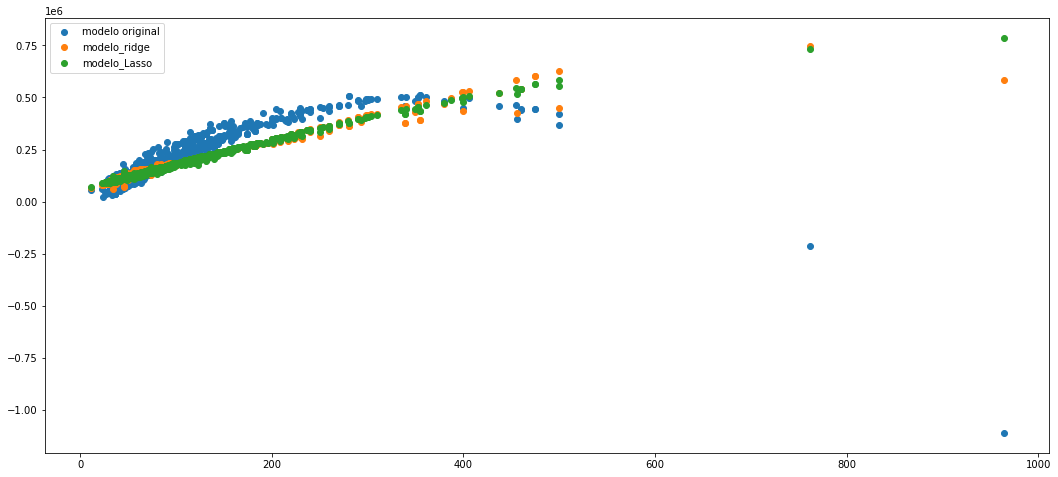

In [54]:
fig = plt.figure(figsize = (18,8))

x = muestra.surface_total_in_m2
y = muestra.ypred
plt.scatter(x,y, label='modelo original')
y = muestra.y_pred_ridge
plt.scatter(x, y, label='modelo_ridge')
y = muestra.y_pred_lasso
plt.scatter(x, y, label='modelo_Lasso')

plt.legend()


### MODELO ORIGINAL

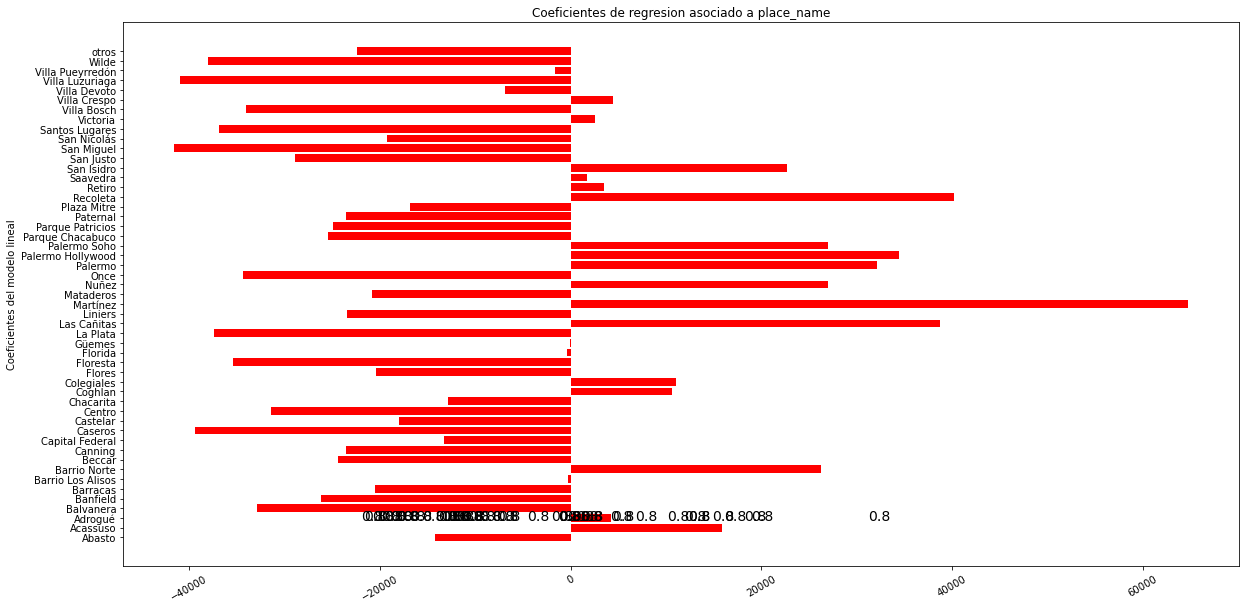

In [55]:
# NECESITO SOLO LOS COEFICIENTES DE LOS LUGARES Y LOS COEFICIENTES SON: SUPERFICIE_TOTAL, SUPERFICIE_POW2, SUP_DESCU_PCT, ABOVE_MEAN
feature_cols = list(pd.DataFrame(Dicto['dummy_place'][0]).columns)
lista_coeficientes = list(linreg.coef_)
lista_coeficientes_dummy_place = lista_coeficientes[4:] #las primera 4 columnas son de otra cosa

fig, ax=plt.subplots(figsize=(20,10))
barras=ax.barh(feature_cols, lista_coeficientes_dummy_place, color='red')
#ax.axhline(0, color='black',linewidth=1)
ax.set_ylabel('Coeficientes del modelo lineal')
plt.xticks(rotation=30);
plt.title('Coeficientes de regresion asociado a place_name')

for barra in barras:
    x=barra.get_x()
    y=barra.get_height()
    ancho=barra.get_width()
    if y>0:
        plt.text(x+ancho/2,y+1,round(y,2),fontsize=14,color='black',ha='center',size=14)
    else:
        plt.text(x+ancho/2,y-10,round(y,2),fontsize=14,color='black',ha='center',size=14)

#################################################################################################
# Clasificacion

vamos a partir de algunas premisas:

1. La mejor generalización la hizo en "La Plata", y que existe la posibilidad de extraer la muestra completa del dataset (deptos)

2. Voy a armar una matriz de correlación y me voy a quedar con todos los place_name que correlaciones con la Plata mas de 55

*4. Voy a eliminar los place_missing de la muestra de entrenamiento

In [56]:
diccionarios = ['Dicto', '']
Dicto.keys()

dict_keys(['data_cruda', 'surface_nan', 'data', 'dummy_place', 'muestra'])

In [57]:
Dictures = ['X', 'y', 'Xtrain', 'ytrain',' Xmuestra', 'X_ridge', 'X_lasso']

In [58]:
data = pd.DataFrame(Dicto['data'][0])

In [59]:
data
#columnas = ['place_name'] #queremos hacer un heat map

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,above_mean,above_median,sup_total_pow2,sup_descubierta_pct
0,apartment,Mataderos,Capital Federal,72000.000000,USD,55.0,55.0,1309.090909,0.0,1.0,3025.0,0.000000
1,apartment,Mataderos,Capital Federal,67000.000000,USD,40.0,28.0,1675.000000,0.0,0.0,1600.0,30.000000
2,apartment,Mataderos,Capital Federal,90000.000000,USD,52.0,48.0,1730.769231,0.0,1.0,2704.0,7.692308
3,apartment,Mataderos,Capital Federal,88000.000000,USD,50.0,38.0,1760.000000,0.0,0.0,2500.0,24.000000
4,apartment,Mataderos,Capital Federal,93600.000000,USD,51.0,46.0,1835.294118,0.0,0.0,2601.0,9.803922
...,...,...,...,...,...,...,...,...,...,...,...,...
15937,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,63759.245132,USD,36.0,33.0,1752.614722,0.0,1.0,1296.0,8.333333
15938,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,63759.245132,USD,36.0,33.0,1752.614722,0.0,1.0,1296.0,8.333333
15939,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,52140.893797,USD,30.0,28.0,1719.899333,0.0,0.0,900.0,6.666667
15940,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,58375.131099,USD,34.0,32.0,1699.005294,0.0,0.0,1156.0,5.882353


In [60]:
# tenes que volver a entrenar el modelo, 1 quitando los place_missing, y dos solo con las columnas rojas del sector izquierdo, buscalo dentro de una iteracion de los coeficintes! 